PREPROCESSING

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta

         Date  Company          Sales
0  2020-01-01        2   72608.623649
1  2020-01-02        2  205074.093589
2  2020-01-02        0   25421.830339
3  2020-01-02        1   57957.790779
4  2020-01-03        2  259426.462059
         Date            Day
0  2020-01-01   New Year Day
1  2020-01-06       Epiphany
2  2020-04-10    Good Friday
3  2020-04-12     Easter Day
4  2020-04-13  Easter Monday


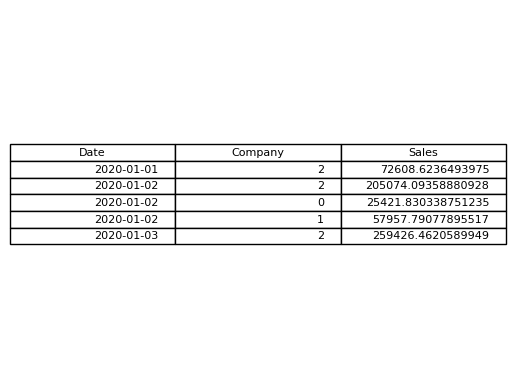

In [62]:
raw_data = pd.read_csv('../csv/raw/caspecoTrainingData.csv', header=0)
holiday_data = pd.read_csv('../csv/raw/swedish_holidays.csv', header=0)
raw_data = raw_data.sort_values('Date').reset_index(drop=True)

fig, ax = plt.subplots()
ax.axis('off')
table = ax.table(cellText=raw_data.head().values, colLabels=raw_data.columns, loc='center')
fig.savefig('../figures/raw_data_table')

print(raw_data.head())
print(holiday_data.head())

In [37]:
'Utility'

def df_convert_dates(df):
    df["Date"] = pd.to_datetime(df["Date"])
    return df

In [13]:
'Base processing'

def missing_dates(df):
    date_counts = df["Date"].value_counts()[df["Date"].sort_values()].to_dict()
    t = np.datetime_as_string(np.arange(datetime.datetime(2020,1,1), datetime.datetime(2023,1,4), datetime.timedelta(days=1)),unit="D")
    missing_dates = []
    for date in t:
        if date not in date_counts :
            missing_dates.append(date)
        if date_counts[date] < 3:
            missing_dates.append(date)
    return missing_dates

def add_dates(lst, df):
    
    comp = np.sort(df['Company'].unique())

    for date in lst:

        new_df = df[df['Date'] == date]

        for c in comp:

            if c not in new_df['Company'].values:  
                new_row = pd.DataFrame({"Date": [date], "Company": [c],"Sales": [-1]})
                df = pd.concat([df, new_row], ignore_index=True)
    
    df = df.sort_values('Date').reset_index(drop=True)
    return df

def add_holidays(df, df_holiday):

    if 'is_holiday' in df.columns:
        return df
    
    df['is_holiday'] = 0

    for date in df_holiday['Date']:
        df.loc[df['Date'] == date,'is_holiday'] = 1

    return df

def add_weekdays(df):

    if 'weekday' in df.columns:
        return df
    
    df['weekday'] = 0

    for i, date in enumerate(df['Date']):

        df.at[i, 'weekday'] = datetime.datetime.strptime(date, "%Y-%m-%d").weekday()

    return df

def create_train_base_csv():

    missing = missing_dates(raw_data)
    df_dates = add_dates(missing, raw_data)
    df_holiday = add_holidays(df_dates, holiday_data)
    df_days = add_weekdays(df_holiday)
    df_days.to_csv('../csv/processed/train_base.csv', index=False)

create_train_base_csv()

NameError: name 'raw_data' is not defined

In [36]:

'All sales imputation functions in this code block!'

'Average sales imputation (3 months)'
base_data = pd.read_csv("../csv/processed/train_base.csv")

"""
Calcs average sales for specific row

If jan 2020 get average of 3 months forward
If dec 2022 or jan 2023 get average of 3 months backward
Otherwise get average from 1 month back to 1 month forward

Avg is calculated by weekday
"""
def calc_average_sales(df :pd.DataFrame, row):
    df = df[(df["Sales"] != -1) & (df["weekday"] == row["weekday"]) & (df["Company"] == row["Company"])]

    date = row["Date"]
    
    start_date = (date - relativedelta(months=1)).replace(day=1)
    end_date = (date + relativedelta(months=1)) + relativedelta(day=31)

    if date.year == 2020 and date.month == 1:
        start_date = date
        end_date = (date + relativedelta(months=3)) + relativedelta(day=31)
    elif (date.year == 2023 and date.month == 1) or (date.year == 2022 and date.month == 12):
        start_date = (date - relativedelta(months=3)).replace(day=1)
        end_date = date
        
    rows_in_range = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

    return rows_in_range["Sales"].sum() / rows_in_range.shape[0]

def add_average_sales(df):
    df = df_convert_dates(df)
    missing_sales_rows = df[df["Sales"] == -1]
    for i, row in missing_sales_rows.iterrows():
        avg_sales = calc_average_sales(df, row)
        df.at[i, "Sales"] = avg_sales
    return df

df_avg_sales = add_average_sales(base_data)
df_avg_sales.to_csv('../csv/processed/train_avg_sales.csv', index=False)



In [45]:
'Average sale of weekday and month'

base_data = pd.read_csv("../csv/processed/train_base.csv")

'Exclude empty sales rows from avg calculation'

def add_avg_weekday_sales(df):
    filtered_data = df[df["Sales"] != -1]
    companies = filtered_data["Company"].unique()
    for company in companies:
        for weekday in range(7):
            filter_mask = (filtered_data["Company"] == company) & (filtered_data["weekday"] == weekday)
            avg = filtered_data.loc[filter_mask, "Sales"].mean()
            base_mask = (df["Company"] == company) & (df["weekday"] == weekday)
            df.loc[base_mask, "avg_weekday_sales"] = avg
    return df

def add_avg_month_sales(df):
    df = df_convert_dates(df)
    filtered_data = df[df["Sales"] != -1]
    companies = filtered_data["Company"].unique()
    for company in companies:
        for month in range(1,13):
            filter_mask = (filtered_data["Company"] == company) & (filtered_data["Date"].dt.month == month)
            avg = filtered_data.loc[filter_mask, "Sales"].mean()
            base_mask = (df["Company"] == company) & (df["Date"].dt.month == month)
            df.loc[base_mask,"avg_month_sales"] = avg
    return df

'Should run this on all training sets with different types of imputed sales?'
new_df = add_avg_weekday_sales(base_data)
new_df = add_avg_month_sales(new_df)
new_df.head(30)


,Date,Company,Sales,is_holiday,weekday,avg_weekday_sales,avg_month_sales
0,2020-01-01,2,72608.623649,1,2,376549.313377,319374.577543
1,2020-01-01,1,-1.000000,1,2,27052.120254,35334.918011
2,2020-01-01,0,-1.000000,1,2,30405.310347,28347.210967
3,2020-01-02,1,57957.790779,0,3,28148.001342,35334.918011
4,2020-01-02,0,25421.830339,0,3,32497.367594,28347.210967
5,2020-01-02,2,205074.093589,0,3,403162.191891,319374.577543
6,2020-01-03,1,95419.861851,0,4,67208.316155,35334.918011
7,2020-01-03,0,64633.125617,0,4,75190.720266,28347.210967
8,2020-01-03,2,259426.462059,0,4,577497.554441,319374.577543
9,2020-01-04,1,138371.630767,0,5,89409.636896,35334.918011


In [21]:
'Model-based imputation missing data'
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

base_data = pd.read_csv("../csv/processed/train_base.csv")


def predict_sales_rft(df):

    if df['Date'].dtype != int:
        # Convert the Date column to numerical values
        df['Date'] = pd.to_datetime(df['Date']).astype(int)

    missing_data = df[df['Sales'] == -1].copy()
    data = df[df['Sales'] != -1]

    X = data[['Date', 'Company', 'is_holiday', 'weekday']]
    y = data['Sales']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    missing_vals = missing_data.drop(['Sales'], axis=1)
    y_pred = model.predict(missing_vals)

    df.loc[df['Sales'] == -1, 'Sales'] = y_pred

    # Test the model
    y_test_pred = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    print('Test MAE:', test_mae)

    # Convert back to string
    df['Date'] = pd.to_datetime(base_data['Date']).dt.strftime('%Y-%m-%d')

    return df

rft_df = predict_sales_rft(base_data)
rft_df.to_csv('../csv/processed/predicted_sales_rft.csv', index=False)
rft_df.head()




Test MAE: 24942.573232479033


,Date,Company,Sales,is_holiday,weekday
0,2020-01-01,2,72608.623649,1,2
1,2020-01-01,1,45588.192035,1,2
2,2020-01-01,0,30300.185094,1,2
3,2020-01-02,1,57957.790779,0,3
4,2020-01-02,0,25421.830339,0,3
